# Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/NeuraVisionLib/')
## ! git reset --hard
# ! git pull

while not 'dataloaders' in os.listdir():
    os.chdir('../')
# os.listdir()

In [ ]:
import os
os.listdir('../../../MyDrive/mass_dataset/')

In [ ]:
! pip install rasterio > install.txt
! rm -rf install.txt

# Main

In [1]:
import os
while not 'dataloaders' in os.listdir():
    os.chdir('../')

from rasterio.errors import NotGeoreferencedWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from dataloaders.mass_roads_dataloader import (
    MassRoadsDataset, custom_collate_fn
)
from models.MULDE.models import MLPs, ScoreOrLogDensityNetwork
import torch.nn.functional as F



In [2]:

# --- Hyperparameters ---
DATA_DIR = '/home/ri/Desktop/Projects/Datasets/Mass_Roads/dataset/'
CHECKPOINT_PATH = 'checkpoints/RoadSegMulde/log_density_segmentation_checkpoint.pth'
BEST_MODEL_PATH = 'checkpoints/RoadSegMulde/best_log_density_segmentation_model.pth'

LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-5
ACCUMULATION_STEPS = 4  # Reduce accumulation steps
BATCH_SIZE = 8  # Reduce batch size to stabilize gradients

# Enable gradient clipping
MAX_GRAD_NORM = 100.0  # Clip gradients to prevent explosions

EPOCHS = 300
WINDOW_SIZE = 128
WINDOW_STRIDE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIGMA_MIN = 0.05
SIGMA_MAX = 0.9
NUM_NOISE_LEVELS = 30
USE_AUTOMATIC_MIXED_PRECISION = False
LOAD_FROM = None #'last' # best or None
LOAD_FROM = 'last' # best or None
# DEBUG = True
DEBUG = False

arithmetic_noise = torch.linspace(SIGMA_MIN, SIGMA_MAX, steps=NUM_NOISE_LEVELS - 1).to(DEVICE)
noise_levels = torch.cat([torch.tensor([0.0], device=DEVICE), arithmetic_noise])
print("Generated Noise Levels:", noise_levels.cpu().numpy())

# --- Dataset Preparation ---
train_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='train', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)#, max_images=50)
val_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='valid', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)#, max_images=20)
test_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='test', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)#, max_images=20)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)


Generated Noise Levels: [0.         0.05       0.08035714 0.11071429 0.14107142 0.17142856
 0.20178571 0.23214285 0.2625     0.29285714 0.32321426 0.35357141
 0.38392854 0.4142857  0.44464284 0.475      0.50535715 0.53571427
 0.56607145 0.5964286  0.6267857  0.6571429  0.6875     0.7178571
 0.74821424 0.7785714  0.80892855 0.8392857  0.86964285 0.9       ]
Total patches available: 536272
Total patches available: 6776
Total patches available: 23716


In [ ]:
def plot_patches_and_distribution_with_counts(sat_patches, map_patches, metadata, n_patches=3):
    """
    Efficiently plots randomly selected satellite patches, road masks, and road pixel distributions.
    
    Args:
        sat_patches (Tensor): Batch of satellite image patches.
        map_patches (Tensor): Batch of road mask patches.
        metadata (List[Tuple[int, int, int]]): Metadata with (image_idx, y, x).
        n_patches (int): Number of patches to visualize.
    """
    n_patches = min(n_patches, sat_patches.shape[0])  # Ensure we do not exceed available patches

    # Randomly select `n_patches` indices from the batch
    selected_indices = random.sample(range(sat_patches.shape[0]), n_patches)

    fig, axes = plt.subplots(n_patches, 3, figsize=(15, 5 * n_patches))

    # Ensure axes is always iterable
    if n_patches == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(selected_indices):
        sat_patch = sat_patches[idx]
        map_patch = map_patches[idx]

        # Convert tensors to numpy
        if isinstance(sat_patch, torch.Tensor):
            sat_patch = sat_patch.cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
        if isinstance(map_patch, torch.Tensor):
            map_patch = map_patch.cpu().numpy()

        # Extract metadata (fix KeyError)
        image_idx, y, x = metadata[idx]  

        # Plot Satellite Patch
        axes[i][0].imshow(sat_patch)
        axes[i][0].set_title(f"Satellite Patch {i+1}\nImage Index: {image_idx}, Coords: ({y}, {x})")
        axes[i][0].axis('off')

        # Plot Map Patch
        axes[i][1].imshow(map_patch, cmap='gray')
        axes[i][1].set_title(f"Map Patch {i+1}")
        axes[i][1].axis('off')

        # Plot Distribution of Road Pixels
        road_pixel_count = np.sum(map_patch)
        non_road_pixel_count = map_patch.size - road_pixel_count
        labels = ['Non-Road', 'Road']
        sizes = [non_road_pixel_count, road_pixel_count]

        axes[i][2].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['gray', 'blue'])
        axes[i][2].set_title(f"Road Pixel Distribution (Patch {i+1})")

    plt.show()


# Count total batches in the dataset
total_batches = len(train_loader)

print(f"Total Batches in Dataset: {total_batches}\n")

# Iterate through the DataLoader and print batch sizes
for batch_idx, (sat_patches, map_patches, metadata) in enumerate(train_loader):
    if sat_patches is None or map_patches is None:
        print(f"Batch {batch_idx+1}: Skipped (Empty Batch)")
        continue  # Skip empty batches

    # Print batch info
    print(f"\nBatch {batch_idx+1}/{total_batches}:")
    print(f"  Requested Batch Size: {BATCH_SIZE}")
    print(f"  Actual Batch Size: {sat_patches.shape[0]}")  # The number of patches in this batch
    print(f"  Patch Shape: {sat_patches.shape}")  # (batch_size, channels, height, width)

    if batch_idx >= 3:  # Stop printing after a few batches to avoid excessive output
        break


# --- Efficiently Load ONE Batch ---
try:
    batch = next(iter(train_loader))  # Load one batch
    sat_patches, map_patches, metadata = batch

    if sat_patches is not None and len(sat_patches) > 0:
        plot_patches_and_distribution_with_counts(sat_patches, map_patches, metadata, n_patches=3)  # Show 3 patches
    else:
        print("No valid patches found in the batch.")

except StopIteration:
    print("No data available in train_loader.")


noise_levels

In [ ]:
def plot_satellite_patch_with_noise(satellite_patch, noise_levels, n_samples=None):
    """
    Plots the original satellite image patch alongside multiple noisy versions.

    Args:
        satellite_patch (Tensor): Single satellite image patch (C, H, W).
        noise_levels (Tensor): Tensor of noise levels to apply.
        n_samples (int): Number of noisy samples to generate (default: all).
    """
    if n_samples is None:
        n_samples = len(noise_levels)  # Use all noise levels

    # Convert tensor to numpy for visualization
    if isinstance(satellite_patch, torch.Tensor):
        satellite_patch = satellite_patch.cpu().numpy()

    # Ensure shape is (H, W, C)
    if satellite_patch.shape[0] in [1, 3]:  # If (C, H, W), convert to (H, W, C)
        satellite_patch = np.transpose(satellite_patch, (1, 2, 0))

    # Normalize to [0,1] for proper visualization
    satellite_patch = (satellite_patch - satellite_patch.min()) / (satellite_patch.max() - satellite_patch.min())

    # Select `n_samples` evenly spaced noise levels
    noise_indices = np.linspace(0, len(noise_levels) - 1, n_samples, dtype=int)
    selected_noise_levels = noise_levels[noise_indices].cpu().numpy()

    fig, axes = plt.subplots(1, n_samples + 1, figsize=(100, 5))

    # Plot the original image
    axes[0].imshow(satellite_patch)
    axes[0].set_title("Original Patch")
    axes[0].axis('off')

    # Generate and apply noise
    for i, noise_level in enumerate(selected_noise_levels):
        noise = np.random.randn(*satellite_patch.shape) * noise_level  # Generate Gaussian noise
        noisy_patch = np.clip(satellite_patch + noise, 0, 1)  # Add noise and clip values to [0,1]

        axes[i + 1].imshow(noisy_patch)
        axes[i + 1].set_title(f"Noise: {noise_level:.3f}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()


# Test with real data from your DataLoader
for batch_idx, (sat_patches, map_patches, _) in enumerate(train_loader):
    if sat_patches is None or sat_patches.shape[0] == 0:
        print(f"Batch {batch_idx+1}: Skipped (Empty Batch)")
        continue  # Skip empty batches

    print(f"\nBatch {batch_idx+1}:")
    print(f"  Satellite Patch Shape: {sat_patches.shape}")  # Debugging step
    print(f"  Selected Noise Levels: {noise_levels.cpu().numpy()}")  # Debugging step

    plot_satellite_patch_with_noise(sat_patches[0], noise_levels)  # Use the first patch in the batch

    if batch_idx > 1:
        break




In [3]:
# --- Model Definition ---
resnet = resnet50(pretrained=True)
resnet = nn.Sequential(
    *list(resnet.children())[:-2],
    nn.AdaptiveAvgPool2d((1, 1))
).to(DEVICE)
for param in resnet.parameters():
    param.requires_grad = False  # Freeze all layers
    param.grad = None  # Ensure no gradients are tracked

mlp = MLPs(
    input_dim=2048 + 1,
    output_dim=WINDOW_SIZE * WINDOW_SIZE,
    units=[4096, 4096],
    layernorm=True,
    dropout=0.1
)
log_density_model = ScoreOrLogDensityNetwork(mlp, score_network=False).to(DEVICE)

optimizer = optim.AdamW(log_density_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler() if USE_AUTOMATIC_MIXED_PRECISION else None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


def calculate_metrics(predictions, targets, threshold=0.5):
    preds = (predictions > threshold).float().cpu().numpy().astype(np.uint8).flatten()
    targets = (targets > 0.5).float().cpu().numpy().astype(np.uint8).flatten()  # Ensure targets are binary
    precision = precision_score(targets, preds, zero_division=1)
    recall = recall_score(targets, preds, zero_division=1)
    f1 = f1_score(targets, preds, zero_division=1)
    iou = jaccard_score(targets, preds, zero_division=1)

    return precision, recall, f1, iou

# --- Save and Load Model ---
def save_model(log_density_model, optimizer, epoch, loss, path):
    directory = os.path.dirname(path)
    os.makedirs(directory, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': log_density_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Model saved at {path}")

def load_checkpoint(path):
    if os.path.exists(path):
        checkpoint = torch.load(path, weights_only=True)
        log_density_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']
    return 0, None


# --- Loss Functions ---
def hybrid_loss(pred, target, alpha=0.8, beta=0.1, gamma=0.01, use_bce=False, smooth=1e-6, debug=DEBUG):
    """
    Hybrid loss function combining:
    - BCE or MSE for pixel-wise similarity
    - Dice Loss for segmentation
    - KL Divergence for distribution learning
    """
    pred_prob = torch.sigmoid(pred)  # Convert logits to probabilities

    if debug:
        print(f"\n[DEBUG] Hybrid Loss Calculation")
        print(f"Pred Shape: {pred.shape}, Min: {pred.min().item()}, Max: {pred.max().item()}")
        print(f"Target Shape: {target.shape}, Min: {target.min().item()}, Max: {target.max().item()}")

    # --- Pixel-wise Loss (BCE or MSE) ---
    if use_bce:
        pixel_loss = nn.BCEWithLogitsLoss()(pred, target)  # Uses raw logits
    else:
        pixel_loss = nn.MSELoss()(pred_prob, target)  # Uses probabilities

    if debug:
        print(f"Pixel Loss: {pixel_loss.item()}")

    # --- Dice Loss ---
    intersection = (pred_prob * target).sum(dim=(1, 2, 3))
    union = pred_prob.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    dice = dice.mean()  # Keep batch dimension

    if debug:
        print(f"Dice Loss: {dice.item()} | Intersection: {intersection.mean().item()} | Union: {union.mean().item()}")

    # --- KL Divergence Loss ---
    eps = 1e-6  # Prevent log(0)
    target_sum = target.sum(dim=(1, 2, 3), keepdim=True) + eps
    pred_sum = pred_prob.sum(dim=(1, 2, 3), keepdim=True) + eps
    target_dist = (target + eps) / target_sum
    pred_dist = (pred_prob + eps) / pred_sum
    kl_div = F.kl_div(pred_dist.log(), target_dist, reduction="batchmean")
    
    if debug:
        print(f"KL Divergence Loss: {kl_div.item()} | Target Sum: {target_sum.mean().item()} | Pred Sum: {pred_sum.mean().item()}")

    # --- Compute Per-Patch Hybrid Loss ---
    batch_size = pred.shape[0]  # Number of patches in the batch
    loss = (alpha * pixel_loss + beta * dice + gamma * kl_div) / batch_size  # Normalize by batch size

    if debug:
        print(f"[Loss] Pixel: {pixel_loss.item():.4f}, Dice: {dice.item():.4f}, KL: {kl_div.item():.4f}, Total: {loss.item():.4f}")


    if debug:
        print(f"Total Loss: {loss.item()}")

    return loss



# --- Forward Pass ---
def forward_pass(satellite_patches, noise_levels, resnet, log_density_model, debug=DEBUG):
    resnet.eval()
    batch_size = satellite_patches.size(0)
    num_noise_levels = len(noise_levels)

    if debug:
        print(f"\n[Forward Pass] Batch Size: {batch_size}, Noise Levels: {num_noise_levels}")
        print(f"Input Satellite Patches Shape: {satellite_patches.shape}")

    # Expand satellite patches for each noise level
    satellite_patches = satellite_patches.repeat_interleave(num_noise_levels, dim=0)

    # Expand noise levels dynamically
    noise_tensor = noise_levels.view(1, -1, 1, 1).repeat(batch_size, 1, WINDOW_SIZE, WINDOW_SIZE).view(-1, 1, WINDOW_SIZE, WINDOW_SIZE)

    if noise_tensor.shape[0] != satellite_patches.shape[0]:
        print(f"[ERROR] Noise Shape Mismatch! Expected {satellite_patches.shape[0]}, got {noise_tensor.shape[0]}")

    if debug:
        print(f"Expanded Satellite Patches Shape: {satellite_patches.shape}")
        print(f"Noise Tensor Shape: {noise_tensor.shape}")

    # Add noise
    noisy_patches = satellite_patches + torch.randn_like(satellite_patches) * noise_tensor

    if debug:
        print(f"Noisy Patches Shape: {noisy_patches.shape}")

    # Extract features using frozen ResNet
    features = resnet(noisy_patches).flatten(start_dim=1)

    if debug:
        print(f"Extracted Features Shape: {features.shape}")

    # Add noise level information to features
    noise_tensor_flat = noise_levels.repeat(batch_size, 1).view(-1, 1)
    features_with_noise = torch.cat([features, noise_tensor_flat], dim=1)

    if debug:
        print(f"Features with Noise Shape: {features_with_noise.shape}")

    # Pass through the log density model
    predictions = log_density_model(features_with_noise)
    predictions = torch.clamp(predictions, min=-10, max=10)

    if debug:
        print(f"Raw Predictions Shape: {predictions.shape}")

    # Reshape final predictions correctly
    final_predictions = predictions.view(batch_size, num_noise_levels, 1, WINDOW_SIZE, WINDOW_SIZE)

    if debug:
        print(f"Final Predictions Shape: {final_predictions.shape}")
        print(f"Final loss Predictions Shape: {final_predictions[:, 0, :, :, :].shape}")
        

    return final_predictions



# --- Training Function ---
def train_one_epoch(train_loader, resnet, log_density_model, noise_levels, optimizer, device, scaler, accumulation_steps):
    resnet.eval()
    log_density_model.train()
    
    total_loss = 0  
    total_patches = 0  
    
    optimizer.zero_grad()
    
    for batch_idx, (satellite_patches, road_maps, _) in enumerate(tqdm(train_loader, desc="Training")):
        if satellite_patches is None or road_maps is None:
            continue
        
        satellite_patches, road_maps = satellite_patches.to(device), road_maps.to(device).float().unsqueeze(1)
        
        # Use autocast only if AMP is enabled
        with torch.autocast(device_type='cuda', enabled=(scaler is not None)):
            predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)[:, 0, :, :, :]
            loss = hybrid_loss(predictions, road_maps)  # Already per patch
        
        if torch.isnan(loss).any():
            print("[ERROR] NaN detected in loss, stopping training.")
            return float('inf')

        # Ensure ResNet remains frozen
        for name, param in resnet.named_parameters():
            if param.grad is not None:
                print(f"[ERROR] ResNet parameter {name} has gradients! It should be frozen.")

        # Backpropagation (handling accumulation)
        if scaler:
            scaler.scale(loss / accumulation_steps).backward()
        else:
            (loss / accumulation_steps).backward()
        
        if DEBUG:
            for name, param in log_density_model.named_parameters():
                if param.grad is not None:
                    print(f"{name} - Grad Norm: {param.grad.norm().item()}")
        
        torch.nn.utils.clip_grad_norm_(log_density_model.parameters(), max_norm=MAX_GRAD_NORM)

        if (batch_idx + 1) % accumulation_steps == 0:
            if scaler:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
        
        # Accumulate per-patch loss correctly
        total_loss += loss.item()  
        total_patches += 1  
    
    return total_loss / total_patches if total_patches > 0 else float('inf')



def validate_one_epoch(val_loader, resnet, log_density_model, noise_levels, device):
    resnet.eval()
    log_density_model.eval()
    total_loss, total_patches = 0, 0
    with torch.no_grad():
        for satellite_patches, road_maps, _ in tqdm(val_loader, desc="Validation"):
            if satellite_patches is None or road_maps is None:
                continue
            satellite_patches, road_maps = satellite_patches.to(device), road_maps.to(device).float().unsqueeze(1)
            predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)[:, 0, :, :, :]
            loss = hybrid_loss(predictions, road_maps)
            total_loss += loss.item() * satellite_patches.size(0)
            total_patches += satellite_patches.size(0)
    return total_loss / total_patches



# --- Main Training Loop ---
def train_model(resnet, log_density_model, train_loader, val_loader, noise_levels, optimizer, scheduler, device, epochs, accumulation_steps, checkpoint_path, best_model_path, load_from='last'):
    best_val_loss = float('inf')
    start_epoch = 0

    # Load checkpoint if available
    if load_from == "last" and os.path.exists(checkpoint_path):
        print(f"Loading last checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        log_density_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        last_loss = checkpoint['loss']
        print(f"Resumed training from epoch {start_epoch} with last loss: {last_loss:.4f}")
    elif load_from == "best" and os.path.exists(best_model_path):
        print(f"Loading best model from {best_model_path}")
        best_model_checkpoint = torch.load(best_model_path, weights_only=False)
        log_density_model.load_state_dict(best_model_checkpoint['model_state_dict'])
        optimizer.load_state_dict(best_model_checkpoint['optimizer_state_dict'])
        best_val_loss = best_model_checkpoint['loss']
        print(f"Best model loaded with validation loss: {best_val_loss:.4f}")
    else:
        print("Starting training from scratch.")

    for epoch in range(start_epoch, epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train_one_epoch(train_loader, resnet, log_density_model, noise_levels, optimizer, device, scaler, accumulation_steps)
        val_loss = validate_one_epoch(val_loader, resnet, log_density_model, noise_levels, device)

        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        save_model(log_density_model, optimizer, epoch, val_loss, checkpoint_path)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(log_density_model, optimizer, epoch, best_val_loss, best_model_path)

    print("Training complete.")



In [ ]:
# --- Run Training ---
train_model(
    resnet=resnet,
    log_density_model=log_density_model,
    train_loader=train_loader,
    val_loader=val_loader,
    noise_levels=noise_levels,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_path=CHECKPOINT_PATH,
    best_model_path=BEST_MODEL_PATH,
    load_from=LOAD_FROM
)


Loading last checkpoint from checkpoints/RoadSegMulde/log_density_segmentation_checkpoint.pth
Resumed training from epoch 22 with last loss: 0.0359
Epoch 23/300


Training:   0%|          | 106/67034 [00:33<5:34:37,  3.33it/s]

In [5]:
# --- Test Evaluation ---
def evaluate_on_test(test_loader, resnet, log_density_model, noise_levels, device):
    """
    Evaluates the model on the test dataset.
    
    Args:
        test_loader (DataLoader): Test dataset loader.
        resnet (nn.Module): Feature extractor.
        log_density_model (nn.Module): Road distribution model.
        noise_levels (Tensor): Tensor of noise levels.
        device (str): Device (cuda or cpu).
    
    Returns:
        Tuple: (Average test loss, list of averaged metrics [Precision, Recall, F1, IoU])
    """
    resnet.eval()
    log_density_model.eval()
    
    test_loss = 0
    metrics = []
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (satellite_patches, road_maps, _) in enumerate(tqdm(test_loader, desc="Testing")):
            if satellite_patches is None or road_maps is None or satellite_patches.numel() == 0:
                # print(f"Skipping empty batch {batch_idx+1}")
                continue  # Skip empty batches

            satellite_patches = satellite_patches.to(device)
            road_maps = road_maps.to(device).float().unsqueeze(1)  # Ensure correct shape

            # Forward pass
            predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)
            predictions = predictions[:, 0, :, :, :]  # Extract first noise level prediction

            # Compute loss
            loss = hybrid_loss(predictions, road_maps)
            test_loss += loss.item()

            # Compute evaluation metrics
            precision, recall, f1, iou = calculate_metrics(torch.sigmoid(predictions), road_maps)
            metrics.append([precision, recall, f1, iou])
            num_batches += 1

    # Compute average loss & metrics
    avg_loss = test_loss / max(num_batches, 1)  # Avoid division by zero
    avg_metrics = np.mean(metrics, axis=0) if len(metrics) > 0 else [0, 0, 0, 0]

    print(f"Test - Loss: {avg_loss:.4f} | Precision: {avg_metrics[0]:.4f} | Recall: {avg_metrics[1]:.4f} | F1: {avg_metrics[2]:.4f} | IoU: {avg_metrics[3]:.4f}")
    
    return avg_loss, avg_metrics



# --- Plot Predictions ---
def plot_predictions(predictions, ground_truth, satellite_images, n_samples=5):
    """
    Plots satellite images, corresponding predictions, and ground truth maps.

    Args:
        predictions (Tensor): Model-predicted road maps (B, H, W).
        ground_truth (Tensor): Ground truth road maps (B, H, W).
        satellite_images (Tensor): Corresponding satellite images (B, C, H, W).
        n_samples (int): Number of samples to visualize (default: 5).
    """
    n_samples = min(n_samples, len(predictions))

    for i in range(n_samples):
        pred = predictions[i].squeeze().cpu().numpy()
        gt = ground_truth[i].squeeze().cpu().numpy()
        sat_img = satellite_images[i].cpu().numpy().transpose(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Satellite Image
        axes[0].imshow(sat_img)
        axes[0].set_title("Satellite Image")
        axes[0].axis("off")

        # Prediction
        axes[1].imshow(pred, cmap="gray")
        axes[1].set_title("Model Prediction")
        axes[1].axis("off")

        # Ground Truth
        axes[2].imshow(gt, cmap="gray")
        axes[2].set_title("Ground Truth")
        axes[2].axis("off")

        plt.show()



Testing: 100%|██████████| 1210/1210 [04:01<00:00,  5.02it/s]


Test - Loss: 0.0720 | Precision: 0.5775 | Recall: 0.0087 | F1: 0.0136 | IoU: 0.0073
Test Loss: 0.0720
Test Metrics - Precision: 0.5775, Recall: 0.0087, F1: 0.0136, IoU: 0.0073


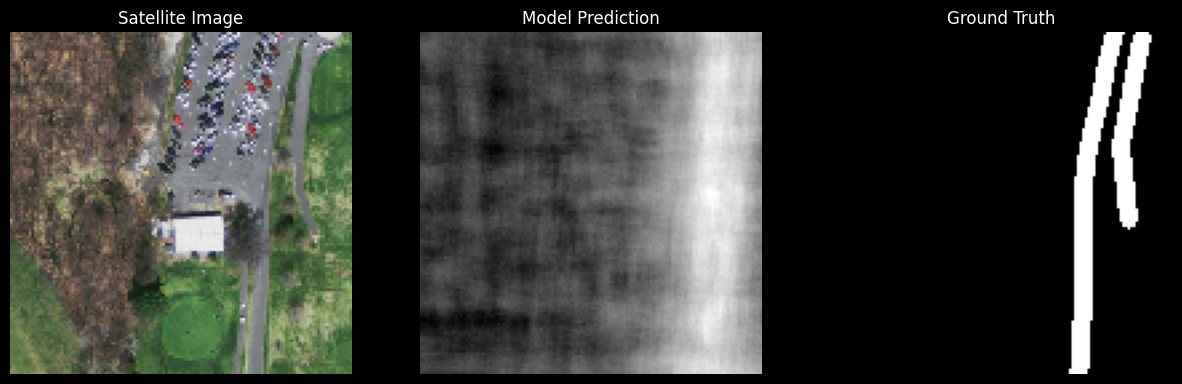

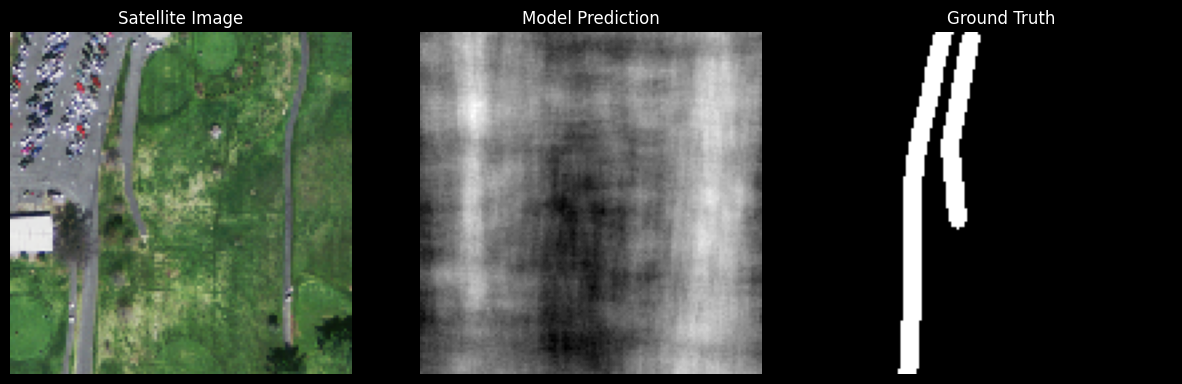

In [6]:
# --- Evaluate on Test Set ---
test_loss, test_metrics = evaluate_on_test(
    test_loader=test_loader,
    resnet=resnet,
    log_density_model=log_density_model,
    noise_levels=noise_levels,
    device=DEVICE
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics - Precision: {test_metrics[0]:.4f}, Recall: {test_metrics[1]:.4f}, F1: {test_metrics[2]:.4f}, IoU: {test_metrics[3]:.4f}")

# --- Get a few validation samples ---
for val_batch in val_loader:
    if val_batch[0] is None:
        continue  # Skip empty batches

    # Unpack batch (ignore metadata)
    sat_patches, road_maps, _ = val_batch  

    # Move to device
    sat_patches, road_maps = sat_patches.to(DEVICE), road_maps.to(DEVICE).float() / 255.0
    road_maps = road_maps.unsqueeze(1)  # Ensure correct shape for model input

    # Generate Predictions
    with torch.no_grad():
        predictions = forward_pass(sat_patches, noise_levels, resnet, log_density_model)
        predictions = predictions[:, 0, :, :, :]  # Extract first noise level prediction

    # Plot the results (only 2 or 3 samples)
    plot_predictions(predictions[:3], road_maps[:3], sat_patches[:3])

    break  # Stop after visualizing the first batch



In [ ]:
# import torch
# import gc
# gc.collect()
# torch.cuda.empty_cache()
